In [1]:
import sys
sys.path.append('../../..')
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import xarray as xr
import random as rd
import platform
import adamod
import torch
import torch.nn.functional as F


from torch.utils.data import DataLoader
from collections import OrderedDict
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from MogrifierLSTM import MogrifierLSTMCell
from utils.dataset import NCDFDatasets
from utils.evaluator import Evaluator
from utils.trainer import Trainer
from datetime import datetime


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device
if (torch.cuda.is_available()):
    torch.cuda.empty_cache()

In [4]:
batch_size = 25
validation_split = 0.2
test_split = 0.2
dropout_rate = 0.2
prediction_window=5
param = {'encoder_layer_size': 3, 'decoder_layer_size': 3, 'kernel_size': 5, 'filter_size': 32}

In [5]:
import xarray as xr
data_path = '../../../data/dataset-ucar-1979-2015-seq5-ystep5.nc'
dataset = xr.open_dataset(data_path)
print(dataset)

<xarray.Dataset>
Dimensions:  (channel: 1, lat: 32, lon: 32, sample: 54047, time: 5)
Coordinates:
  * lat      (lat) int32 -54 -52 -50 -48 -46 -44 -42 -40 ... -6 -4 -2 0 2 4 6 8
  * lon      (lon) int32 278 280 282 284 286 288 290 ... 330 332 334 336 338 340
Dimensions without coordinates: channel, sample, time
Data variables:
    x        (sample, time, lat, lon, channel) float32 ...
    y        (sample, time, lat, lon, channel) float32 ...
Attributes:
    description:  The variables have air temperature values and are separable...


In [6]:
#In these experiments y has dimensions [batch, channel, lat, lon] as opposed to [batch, channel, time, lat, lon] to
#avoid dimension conflict with conv kernels
data = NCDFDatasets(dataset, val_split = 0.2, test_split = 0.2)
train_data = data.get_train()
val_data = data.get_val()
test_data = data.get_test()

In [7]:
print("-----Train-----")
print("X : ", train_data.x.shape)
print("Y : ", train_data.y.shape)
print("-----Val-----")
print("X : ", val_data.x.shape)
print("Y : ", val_data.y.shape)
print("-----Test-----")
print("X : ", test_data.x.shape)
print("Y : ", test_data.y.shape)

-----Train-----
X :  torch.Size([32429, 1, 5, 32, 32])
Y :  torch.Size([32429, 1, 5, 32, 32])
-----Val-----
X :  torch.Size([10809, 1, 5, 32, 32])
Y :  torch.Size([10809, 1, 5, 32, 32])
-----Test-----
X :  torch.Size([10809, 1, 5, 32, 32])
Y :  torch.Size([10809, 1, 5, 32, 32])


In [8]:
seed = 1000
np.random.seed(seed)
rd.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True

def init_seed(seed):
    np.random.seed(seed)
    
init_seed = init_seed(seed)

In [9]:
params = {'batch_size': batch_size,
          'num_workers': 4,
          'worker_init_fn': init_seed}

train_loader = DataLoader(dataset=train_data, shuffle=True, **params)
val_loader = DataLoader(dataset=val_data, shuffle=False, **params)
test_loader = DataLoader(dataset=test_data, shuffle=False, **params)

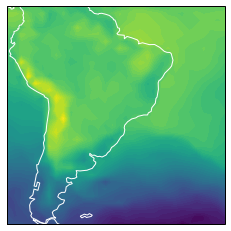

In [10]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy
#sample, ch, time, lat, lon
sst = train_data.y[0, 0, 0, :, :]
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lons, lats, sst, 60,
             transform=ccrs.PlateCarree())
ax.coastlines(color='white')

plt.show()

In [11]:
class Mish(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        #inlining this saves 1 second per epoch (V100 GPU) vs having a temp x and then returning x(!)
        return x *( torch.tanh(F.softplus(x)))

In [12]:
class CustomConv2d(torch.nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1,
                 bias=False, padding_mode='zeros', weight=None):
        super().__init__(in_channels, out_channels, kernel_size, stride=stride,
                 padding=padding, dilation=dilation,
                 bias=bias, padding_mode=padding_mode)
        
        self.padding = [kernel_size // 2, kernel_size // 2]
        
    def forward(self,input, weight=None):
        if (weight is not None):
            return F.conv2d(input, weight.permute(1,0,2,3), self.bias, self.stride,
                        self.padding, self.dilation)
        else:
            return F.conv2d(input, self.weight, self.bias, self.stride,
                        self.padding, self.dilation)

In [13]:
class EncoderCNN(torch.nn.Module):
    def __init__(self, layer_size, kernel_size, initial_out_channels, initial_in_channels, device):
        super(EncoderCNN, self).__init__()
        self.device = device
        self.layer_size = layer_size
        self.conv_layers = torch.nn.ModuleList()
        self.mish_layers = torch.nn.ModuleList()
        self.bn_layers = torch.nn.ModuleList()
        self.decode_bn_layers = torch.nn.ModuleList()
        
        in_channels = initial_in_channels
        out_channels = initial_out_channels
        for i in range(self.layer_size):
            self.conv_layers.append(CustomConv2d(in_channels = in_channels, out_channels = out_channels,
                                                kernel_size = kernel_size))
            self.mish_layers.append(Mish())
            self.bn_layers.append(torch.nn.BatchNorm2d(out_channels))
            self.decode_bn_layers.append(torch.nn.BatchNorm2d(in_channels))
            in_channels = out_channels
            
        self.conv_reduce = CustomConv2d(in_channels = in_channels, out_channels = 1,
                                                kernel_size = 1)
            
            
    def forward(self, x, decode=False):
        if (decode):
            x = self.conv_reduce(x, self.conv_reduce.weight)
            for i in range(self.layer_size-1, -1, -1):
                x = self.conv_layers[i](x, self.conv_layers[i].weight)
                x = self.decode_bn_layers[i](x)
                x = self.mish_layers[i](x)
        else:
            for i in range(self.layer_size):
                x = self.conv_layers[i](x)
                x = self.bn_layers[i](x)
                x = self.mish_layers[i](x)
            x = self.conv_reduce(x)
        return x

In [14]:
class STModel(torch.nn.Module):
    def __init__(self, encoder_layer_size, decoder_layer_size, kernel_size, out_channels, in_channels, input_width, input_height,
                prediction_window, device):
        super(STModel, self).__init__()
        self.device = device
        self.prediction_window = prediction_window
        self.encoder = EncoderCNN(layer_size = encoder_layer_size, kernel_size = kernel_size,
                                initial_out_channels = out_channels,
                                initial_in_channels = in_channels, device=device)
        self.recurrent_encoder = torch.nn.LSTMCell(input_width*input_height, input_width*input_height);
       
        
    def forward(self, x, states):
        batch, channel, time, lat, lon = x.size()
        x = x.view(batch*time, channel, lat, lon)
        x = self.encoder(x)
        
        x = x.view(batch, time, -1)
        h = states[0]
        c = states[1]
        for i in range(time):
            h,c = self.recurrent_encoder(x[:,i,:],(h,c))
            
        outputs = torch.zeros(batch, self.prediction_window, lat*lon, device=self.device)    
        inputLSTM = torch.zeros(h.size(), device=self.device)
        for i in range(self.prediction_window):
            h,c = self.recurrent_encoder(inputLSTM,(h,c))
            inputLSTM = h
            outputs[:,i,:] = h
            
        x = outputs.contiguous().view(batch*self.prediction_window, channel, lat, lon)
        x = self.encoder(x, decode=True)
        x = x.view(batch, channel, self.prediction_window, lat, lon)
        return x
        

In [15]:
model = STModel(encoder_layer_size = param['encoder_layer_size'], decoder_layer_size = param['decoder_layer_size']
                ,kernel_size = param['kernel_size'], out_channels = param['filter_size'],
                in_channels = train_data.x.shape[1], input_width = train_data.x.shape[3], 
                input_height = train_data.x.shape[4], prediction_window = prediction_window, device=device).to(device)
criterion = torch.nn.L1Loss()
#optimizer_params = {'lr': 0.001}
#optimizer = torch.optim.Adam(net.parameters(), **optimizer_params)
opt_params = {'lr': 0.001, 
              'beta3': 0.999}
optimizer = adamod.AdaMod(model.parameters(), **opt_params)
model

STModel(
  (encoder): EncoderCNN(
    (conv_layers): ModuleList(
      (0): CustomConv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=[2, 2], bias=False)
      (1): CustomConv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=[2, 2], bias=False)
      (2): CustomConv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=[2, 2], bias=False)
    )
    (mish_layers): ModuleList(
      (0): Mish()
      (1): Mish()
      (2): Mish()
    )
    (bn_layers): ModuleList(
      (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (decode_bn_layers): ModuleList(
      (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm2d(32, ep

In [17]:
model_path = os.path.join('../../../models/CFSR/5_step/T_MAE' + '_' + datetime.now().strftime('m%md%d-h%Hm%Ms%S') + '.pth.tar')
trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, 100, device, False, model_path, True, 5)


In [17]:
train_losses, val_losses = trainer.train_evaluate()

Train - Epoch 0, Epoch Loss: 18.792193
Val Avg. Loss: 18.517394
=> Saving a new best
Train - Epoch 1, Epoch Loss: 17.694120
Val Avg. Loss: 17.168340
=> Saving a new best
Train - Epoch 2, Epoch Loss: 16.335069
Val Avg. Loss: 15.832004
=> Saving a new best
Train - Epoch 3, Epoch Loss: 14.952484
Val Avg. Loss: 14.414895
=> Saving a new best
Train - Epoch 4, Epoch Loss: 13.558487
Val Avg. Loss: 13.019798
=> Saving a new best
Train - Epoch 5, Epoch Loss: 12.162551
Val Avg. Loss: 11.488962
=> Saving a new best
Train - Epoch 6, Epoch Loss: 10.713065
Val Avg. Loss: 10.199225
=> Saving a new best
Train - Epoch 7, Epoch Loss: 9.414455
Val Avg. Loss: 8.961227
=> Saving a new best
Train - Epoch 8, Epoch Loss: 8.190914
Val Avg. Loss: 7.903279
=> Saving a new best
Train - Epoch 9, Epoch Loss: 7.170563
Val Avg. Loss: 6.937295
=> Saving a new best
Train - Epoch 10, Epoch Loss: 6.542202
Val Avg. Loss: 6.168282
=> Saving a new best
Train - Epoch 11, Epoch Loss: 5.636903
Val Avg. Loss: 5.737060
=> Saving

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001FC6F837A60>
Traceback (most recent call last):
  File "c:\users\mario\anaconda3\envs\pytorch\lib\site-packages\torch\utils\data\dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "c:\users\mario\anaconda3\envs\pytorch\lib\site-packages\torch\utils\data\dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "c:\users\mario\anaconda3\envs\pytorch\lib\multiprocessing\process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "c:\users\mario\anaconda3\envs\pytorch\lib\multiprocessing\popen_spawn_win32.py", line 104, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
KeyboardInterrupt: 
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\users\mario\anaconda3\envs\pytorch\lib\site-packages\IPython\core\interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-be0b857adfcf>", line 1, in <module>
    train_losses, val_losses = trainer.train_evaluate()
  File "../../..\utils\trainer.py", line 22, in train_evaluate
    self.train(train_losses)
  File "../../..\utils\trainer.py", line 50, in train
    epoch_train_loss += loss.detach().item()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\users\mario\anaconda3\envs\pytorch\lib\site-packages\IPython\core\interactiveshell.py", line 2034, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File 

KeyboardInterrupt: 

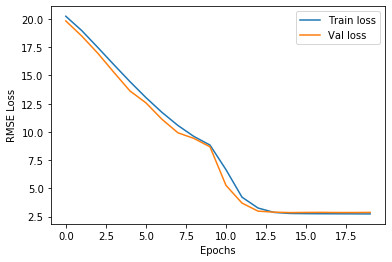

In [19]:
epochs = np.arange(1,len(val_losses))
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['Train loss', 'Val loss'], loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("RMSE Loss")
plt.show()

In [18]:
#trainer.path = '../../../models/STTSModel_m04d08-h16m29s13.pth.tar'
model, optimizer, epoch, loss = trainer.load_model()
iter_test_loss = 0.0
model.eval()
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        x,y = x.to(device), y.to(device)
        states = trainer.init_hidden(x.size()[0], x.size()[3]*x.size()[4])
        output = model(x, states)
        loss = criterion(output, y)
        iter_test_loss += loss.detach().item()
        break
#test_loss = iter_test_loss/len(test_loader)
#loss_type = type(criterion).__name__
#print(f'STConvS2S {loss_type}: {test_loss:.4f}')

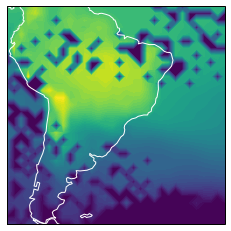

In [19]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy
#sample, ch, time, lat, lon
sst = output[0, 0, 0, :, :].cpu()
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lons, lats, sst, 60,
             transform=ccrs.PlateCarree())
ax.coastlines(color='white')

plt.show()

In [18]:
trainer.path = '../../../models/CFSR/5_step/STFModel_MAE_m04d14-h17m18s49.pth.tar'
model, optimizer, epoch, loss = trainer.load_model()
trainer.model = model
trainer.optimizer = optimizer
train_losses, val_losses = trainer.train_evaluate()

Train - Epoch 0, Epoch Loss: 4.624236
Val Avg. Loss: 4.832166
=> Saving a new best
Train - Epoch 1, Epoch Loss: 4.621683
Val Avg. Loss: 4.837497
Train - Epoch 2, Epoch Loss: 4.617791
Val Avg. Loss: 4.883531
Train - Epoch 3, Epoch Loss: 4.615917
Val Avg. Loss: 4.826341
=> Saving a new best
Train - Epoch 4, Epoch Loss: 4.610372
Val Avg. Loss: 4.833091
Train - Epoch 5, Epoch Loss: 4.608109
Val Avg. Loss: 4.844962
Train - Epoch 6, Epoch Loss: 4.606327
Val Avg. Loss: 4.838608
Train - Epoch 7, Epoch Loss: 4.575250
Val Avg. Loss: 4.621185
=> Saving a new best
Train - Epoch 8, Epoch Loss: 4.323165
Val Avg. Loss: 4.566659
=> Saving a new best
Train - Epoch 9, Epoch Loss: 4.304867
Val Avg. Loss: 4.554861
=> Saving a new best
Train - Epoch 10, Epoch Loss: 4.298080
Val Avg. Loss: 4.562058
Train - Epoch 11, Epoch Loss: 4.291560
Val Avg. Loss: 4.564703
Train - Epoch 12, Epoch Loss: 4.201540
Val Avg. Loss: 4.455105
=> Saving a new best
Train - Epoch 13, Epoch Loss: 4.134327
Val Avg. Loss: 4.380708
=>